In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)


# Bayesian Hypothesis Testing

Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``

# Reference for Bayesian t-test


> Kruschke J, **Doing Bayesian Data Analysis**, Ch. 12

# Drug trial evaluation

* We  want to  evaluate  of a drug that is supposed to increase intelligence.

* We have IQ measures  of:
    * 47 individuals receiving the drug  (treatment group)
    * 42 individuals  receiving the placebo (control group). 
    
* Some observations are however far from the mean.

In [2]:
iq_drug = np.array ([101,100,102,104,105,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,104,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,103,103,100,101,103,104,100,101])
iq_placebo = np.array ([ 99,101,100,101,99,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,98,99])



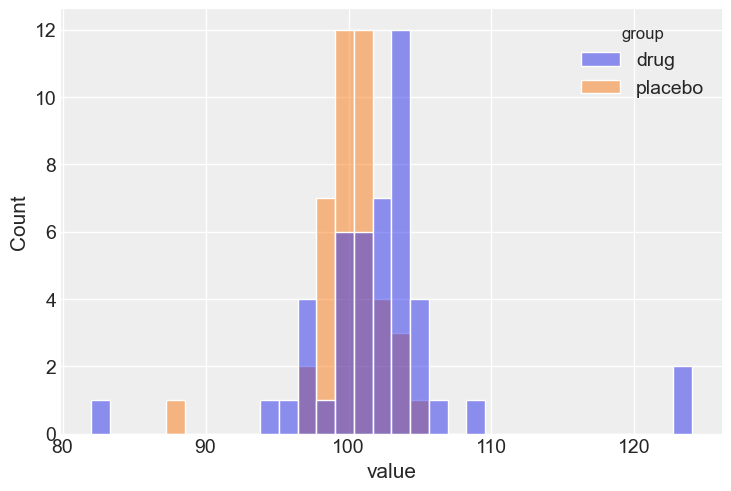

In [3]:
y  = pd.DataFrame(dict(value=np.r_[iq_drug, iq_placebo], group=np.r_[['drug']*len(iq_drug), ['placebo']*len(iq_placebo)]))
sns.histplot(data=y, x="value", hue="group");

# Research question
* The sample mean of the drug group  is superior, but there is a lot of variability within groups, and the variances of the two groups also appear to differ.


* There also appear to be some outliers.


* Are these groups credibly different?


* Is the drug credibly associated to a higher  IQ? 

# Research question

* We have two samples, from which we can compute:

    * observed means, also known as sample means: ($\bar{y}_1$, $\bar{y}_2$) 

    * sample standard deviations ($s_1, s_2$) 

    * numerosity ($n_1, n_2$)


* The sample are drawn from two populations, whose actual parameters ($\mu_1, \mu_2, \sigma_1, \sigma_2$) are unknown.


* Does the sample provide enough information, to conclude that $\mu_2 >  \mu_1$ with probability 95%?

# Main idea

* We will fit a normal-normal model on each group.


* This will make inference about $\mu_1, \mu_2, \sigma_1, \sigma_2$.


* Eventually we will study the difference ($\mu_1 - \mu_2$) between the means of the two groups, in order to ascertain whether the difference is statistically significant.

Recall the normal-normal model (treating $\sigma$ as a parameter):
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu}) \\
\sigma &  \sim \text{half-normal}(\xi) \\
y & \sim N(\mu, \sigma) \\
\end{align*}


# Prior for $\mu_{\text{drug}}$ and $\mu_{\text{placebo}}$

* We assign a normal prior to both means.


* The mean IQ of the population is 100 and extreme values of IQ are 60 and 140.


* The  mean IQ of the population could lie in (80, 120). Thus:

$$
\mu_{\text{drug}}   \sim  N (100, 10 )
$$


* We assign the same priors to both groups, so that we are not favoring a group over another a priori.

$$
\mu_{\text{placebo}}   \sim  N (100, 10 )
$$

# Prior information 

* The IQ can be interpreted according to the <a href="https://www.123test.com/interpretation-of-an-iq-score/"> IQ scale meaning </a>.

    * its  mean in the population is  about 100
    * the IQ is generally assumed to be normally distributed. 
    *  extreme values of IQ  are 60 ( cognitively impaired) and 140 (gifted). 
    * a plausible value of standard devation is about  20 , imposing  $\sigma$= (100 - 60)/2 = (140-100)/2



In [4]:
#Here we tune the half-normal prior for sigma, adjusting the scale to have the median close to 20.
from scipy.stats import halfnorm
# this yields a  diffuse prior, but still defined over plausible range. 
pd.DataFrame(halfnorm.rvs(scale=30, size=10000)).describe()

,0
count,10000.000000
mean,24.089939
std,18.145484
min,0.004981
25%,9.808766
50%,20.401381
75%,34.519428
max,114.781916


## Likelihood


* Assuming a Gaussian distribution of the observations,  we have:

$$y^{(drug)}_i \sim N(\mu_{\text{drug}}, \sigma_{\text{drug}})$$

$$y^{(placebo)}_i \sim N(\mu_{\text{placebo}}, \sigma_{\text{placebo}})$$

where $i$ refers to the $i$-th individual in the group.



#  The probabilistic model

\begin{align}
\mu_{\text{drug}} & \sim N(100,10) \\
\sigma_{\text{drug}} & \sim \text{half-normal} (30) \\
y_{\text{drug},i}  & \sim N(\mu_{\text{drug}}, \sigma_{\text{drug}}) \\
\\
\mu_{\text{placebo}} & \sim N(100,10) \\
\sigma_{\text{placebo}} & \sim \text{half-normal} (30) \\
y_{\text{placebo}_i}  & \sim N(\mu_{\text{placebo}}, \sigma_{\text{placebo}})\\
\end{align}


In [28]:
#full model

with pm.Model() as  normal_model:
    mu_drug              = pm.Normal         ('mu_drug',          mu = 100,  sd = 10)
    mu_placebo        = pm.Normal          ('mu_placebo',    mu = 100,  sd = 10)
    sigma_drug         = pm.HalfNormal ('sigma_drug',      sigma=30)
    sigma_placebo   = pm.HalfNormal ('sigma_placebo', sigma=30)

    
    #likelihood for the two groups
    y_drug         = pm.Normal  ('y_1',  mu=mu_drug,      sigma=sigma_drug,       observed= iq_drug)
    y_placebo   = pm.Normal  ('y_2',  mu=mu_placebo, sigma=sigma_placebo, observed= iq_placebo)

# Comparing two means $\mu_1$ and $\mu_2$

We consider  the difference between the means of the populations:
$$\mu_1 - \mu_2$$ 

* We  can defineit   as a *deterministic* variables in PyMC3, as it is a function of two parameters;  their sampled values will be part of the output.


* We will have its posterior samples in the trace.

In [29]:
with normal_model:
    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_drug - mu_placebo)
    normal_trace    = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_placebo, sigma_drug, mu_placebo, mu_drug]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


# Checking convergence

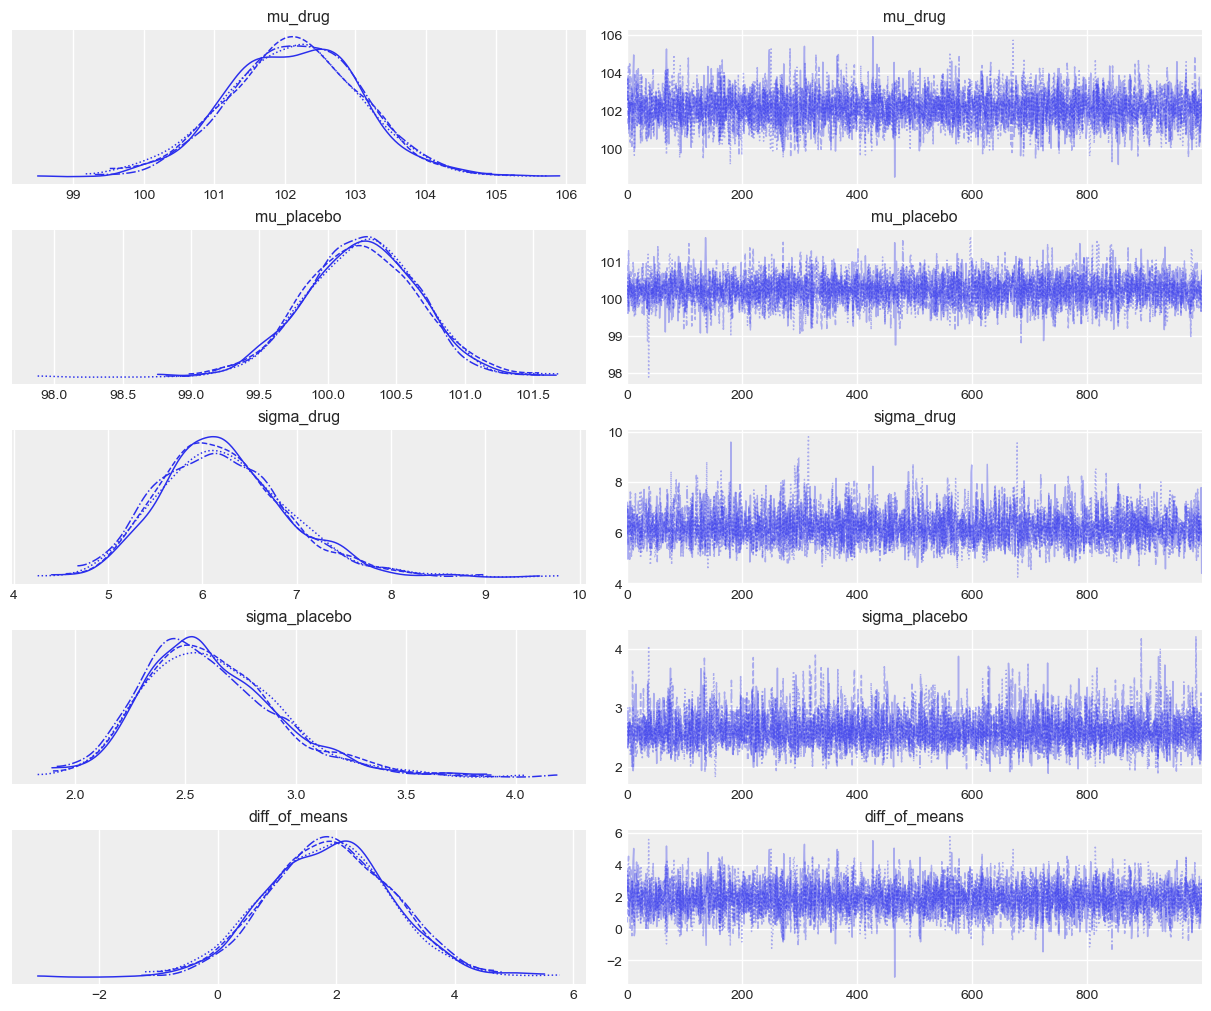

In [7]:
az.plot_trace(trace);

In [8]:
az.summary(trace,  hdi_prob=0.9)
#the hdi of the means of the two groups overlap.
#the hdi's of the two groups overlap (though by a rather narrow margin) and we cannot draw any strong conclusion

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_drug,102.133,0.943,100.570,103.636,0.013,0.009,5152.0,2850.0,1.0
mu_placebo,100.247,0.410,99.556,100.883,0.006,0.004,5081.0,3223.0,1.0
sigma_drug,6.220,0.674,5.186,7.351,0.009,0.007,5761.0,3138.0,1.0
sigma_placebo,2.619,0.312,2.119,3.099,0.004,0.003,5788.0,3052.0,1.0
diff_of_means,1.886,1.035,0.232,3.614,0.014,0.011,5182.0,2729.0,1.0


# Posterior predictive checks

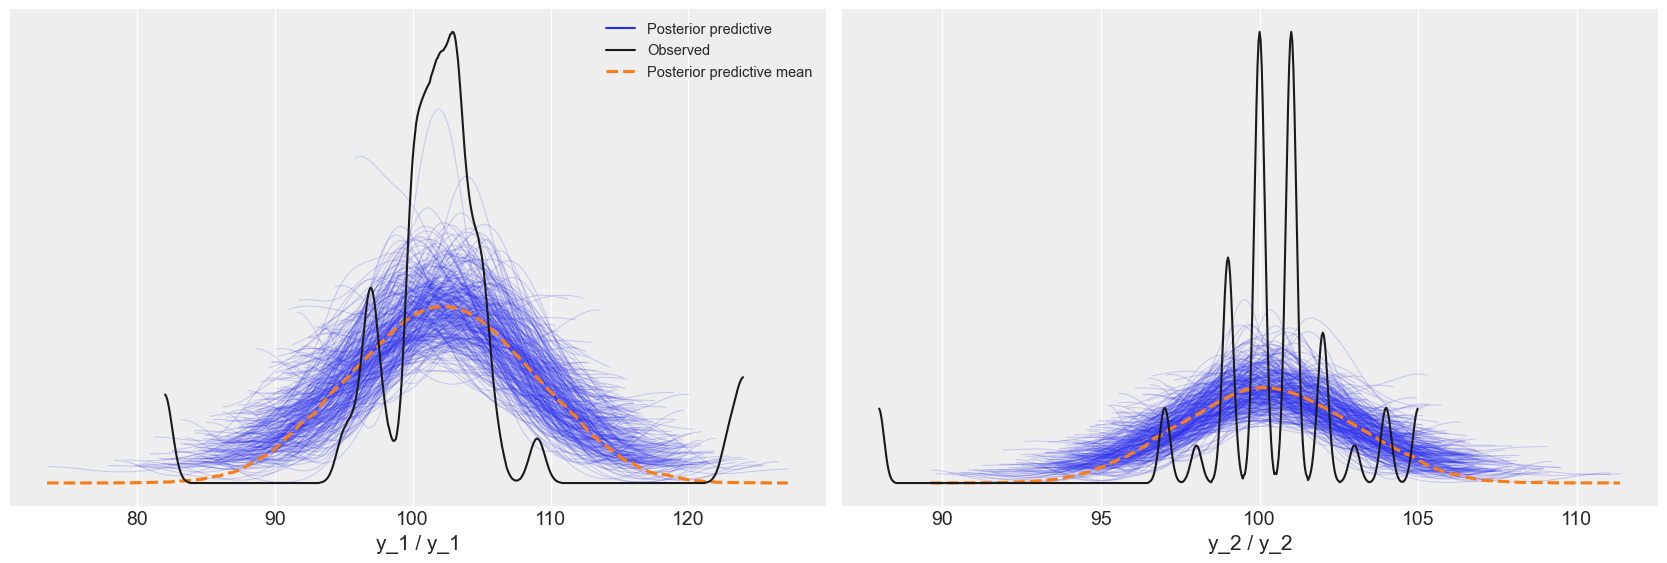

In [11]:
with normal_model:
     ppc = pm.sample_posterior_predictive(trace, samples=300)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=normal_model));

# Discussion
* The density is too low in the center of the distribution.
* For the moment, we continue the analysis with our current model.
* Later we will refine the model.


# Assessing the credibility of the difference being 0
* We can assess the credibility of a $\mu_1 - \mu_2 = 0$.


* This is the hypothesis of  the mean IQ being the same in the two groups. 


*  We thus  examine the posterior distribution of  $\mu_1 - \mu_2  and we will check  whether 0  falls in a region of high density or not.


* If the null value is far from the most credible values, we  reject it.

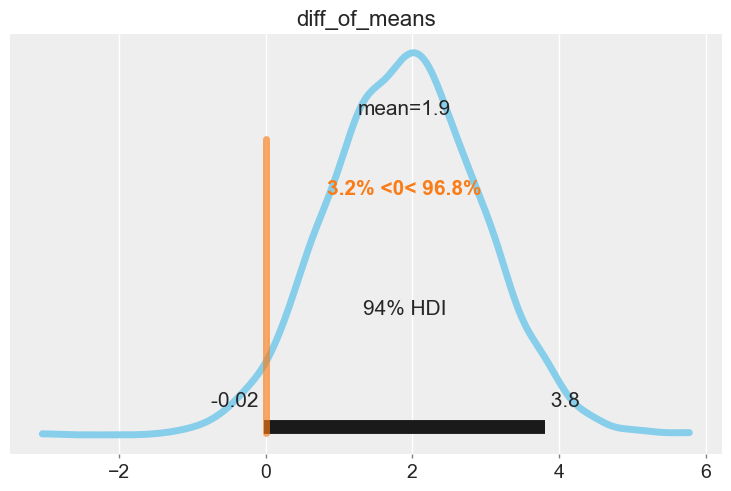

In [12]:
az.plot_posterior(trace, var_names=['diff_of_means'],  ref_val=0, color='#87ceeb', linewidth=5);

# Discussion

* As the value of 0 is out of the 95 HDI, we  reject it: it is not plausible.


* The difference between the two means is 1.9 on average.



*  The 95% HDI of the difference of means falls well above zero, and about 97% of the credible values are greater than zero. 


* Thus the groups’ means are credibly different. 


* Bayesian analysis yields the posterior distribution of credible values, which we can use to take  conclusions


## Robust likelihood

* We now adopt   a Student-t distribution to describe the distributions of the scores in each group. This choice adds robustness to the analysis, as a T distribution is less sensitive to outlier observations, relative to a normal distribution.


* We use a Student-t distribution with 4 degrees of freedom.



* The likelihood functions of our models become:

$$y_{\text{drug},i} \sim StudentT(\mu_{\text{drug}}, \sigma_{\text{drug}}, \nu=4)$$

$$y_{\text{placebo},i} \sim StudentT(\mu_{\text{placebo}}, \sigma_{\text{placebo}},  \nu=4)$$


In [19]:
with pm.Model() as student_model:
    #prior are  unchanged.
    mu_drug_t              = pm.Normal         ('mu_drug_t',          mu = 100,  sd = 5)
    mu_placebo_t        = pm.Normal          ('mu_placebo_t',    mu = 100,  sd = 5)
    sigma_drug_t         = pm.HalfNormal ('sigma_drug_t',      sigma=25)
    sigma_placebo_t    = pm.HalfNormal ('sigma_placebo_t', sigma=25)

    #But now we adopt a robust likelihood. 
    #For simplicity we use a Student T with nu=4.  A more sophisticated approach would be to put a prior also on nu, but
    #that makes the model more complex to sample. 
    group1 = pm.StudentT ('drug',       nu=4, mu=mu_drug_t,       sd=sigma_drug_t,       observed= iq_drug)
    group2 = pm.StudentT ('placebo', nu=4, mu=mu_placebo_t,  sd=sigma_placebo_t, observed= iq_placebo)
    
    #Derived quantities:
    diff_of_means = pm.Deterministic('diff_of_means', mu_drug_t - mu_placebo_t)
    student_trace     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_placebo_t, sigma_drug_t, mu_placebo_t, mu_drug_t]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


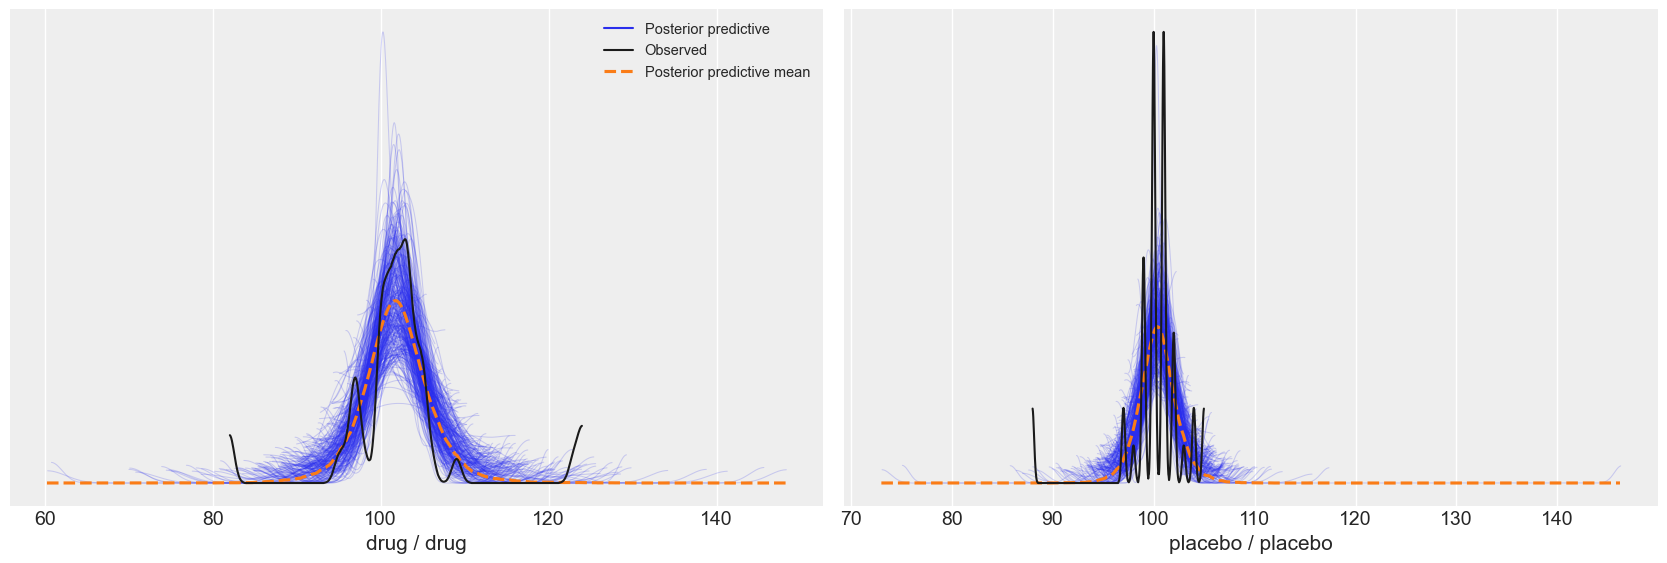

In [20]:
#the fit is better compare to the normal model, though not yet perfect for the placebo group.
with student_model:
    ppc_t = pm.sample_posterior_predictive(student_trace, samples=300)
    az.plot_ppc(az.from_pymc3(posterior_predictive=   ppc_t, model= student_model));

In [21]:
# the sigma decreases by almost a half compared to the Gaussian model, as the student distribution filters outliers.
# as a results, the hdi become shorter, and now there is longer overlap between the hdi of the two groups.
# we can thus conclude that there significant difference between the means of the two groups.
pd.concat( [az.summary(student_trace,  hdi_prob=0.9), az.summary(trace, hdi_prob=0.9) ])

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_drug_t,101.799,0.501,101.001,102.618,0.007,0.005,4983.0,2898.0,1.0
mu_placebo_t,100.436,0.256,100.004,100.834,0.004,0.003,4425.0,2959.0,1.0
sigma_drug_t,2.991,0.475,2.219,3.726,0.006,0.004,6858.0,3410.0,1.0
sigma_placebo_t,1.415,0.225,1.040,1.746,0.003,0.002,4798.0,3355.0,1.0
diff_of_means,1.363,0.557,0.515,2.330,0.008,0.006,4953.0,2966.0,1.0
mu_drug,102.133,0.943,100.570,103.636,0.013,0.009,5152.0,2850.0,1.0
mu_placebo,100.247,0.410,99.556,100.883,0.006,0.004,5081.0,3223.0,1.0
sigma_drug,6.220,0.674,5.186,7.351,0.009,0.007,5761.0,3138.0,1.0
sigma_placebo,2.619,0.312,2.119,3.099,0.004,0.003,5788.0,3052.0,1.0
diff_of_means,1.886,1.035,0.232,3.614,0.014,0.011,5182.0,2729.0,1.0


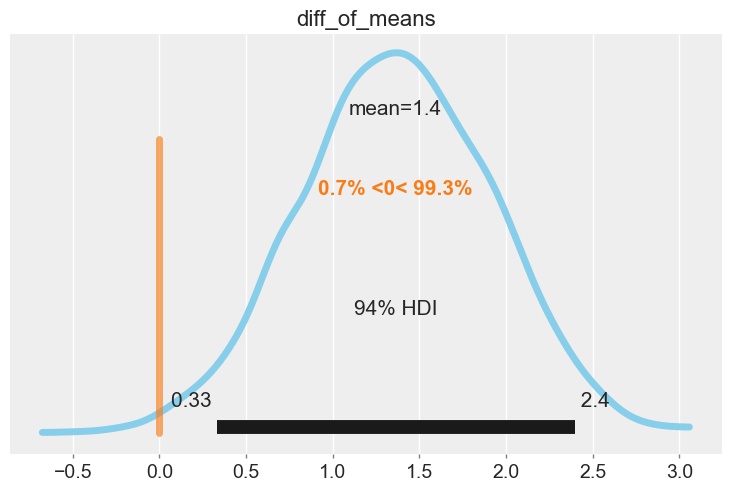

In [23]:
# the significance of the difference between the two groups is now stronger
az.plot_posterior(student_trace, var_names=['diff_of_means'],  ref_val=0, color='#87ceeb', linewidth=5);

# Exercise 1: effect size

A further indicator used to  compare the means of the two populations is *effect size* (Cohen's $d$):

$$
\displaystyle
\frac{\mu_2 - \mu_1}{\sigma_P}$$ 

where  $\sigma_P$ is the pooled standard deviation,  $\sigma_P = \sqrt{ \frac{\sigma_2^2 + \sigma_1^2}{2} }$

* Effect size is  the amount of change induced by the treatment relative to the standard deviation. It is often used in medical studies.


* Compare the two groups by using this indicator.

# Exercise 1: compute the probability of the effect size being small, medium or large, given the observed data

$$
\displaystyle
\frac{\mu_2 - \mu_1}{\sqrt{\frac{\sigma_2^2 + \sigma_1^2}{2}}}
$$

Interpretation:
* small  effect ($0 \leq d \leq 0.5$)
* medium effect  ($0.5 \leq d \leq 1$)
* large  effect ($d >  1$)

* The same guidelines can be used to interpret negative values of  $d$.






* Hints:


    * define `effect_size` as a deterministic variable of the model.


    * use `d  = az.extract_dataset(trace, var_names="effect_size")` to access the values of effect size from the trace.

# A second exercise 

* It is quite common to assume that two groups have the same standard deviation $\sigma$ rather than two independent standard deviations $\sigma_1$ and $\sigma_2$.


* Rework the model accordingly and verify via WAIC which model variant provides the best fit to the data.


* Point out your conclusion analyzing the posterior distribution of the difference of the means and the Cohen mean using the chosen model.

In [ ]:
with pm.Model() as model_t2:
    #prior are  unchanged.
    mu_drug_t              = pm.Normal         ('mu_drug_t',          mu = 100,  sd = 5)
    mu_placebo_t        = pm.Normal          ('mu_placebo_t',    mu = 100,  sd = 5)
    sigma_both                = pm.HalfNormal  ('sigma_both',      sigma=25)


    #But now we adopt a robust likelihood. 
    #For simplicity we use a Student T with nu=4.  A more sophisticated approach would be to put a prior also on nu, but
    #that makes the model more complex to sample. 
    group1 = pm.StudentT ('drug',       nu=4, mu=mu_drug_t,       sd=sigma_both,       observed= iq_drug)
    group2 = pm.StudentT ('placebo', nu=4, mu=mu_placebo_t,  sd=sigma_both,      observed= iq_placebo)
    
    #Derived quantities:
    diff_of_means_t2 = pm.Deterministic('diff_of_means_t2', mu_drug_t - mu_placebo_t)
    effect_size_t2         = pm.Deterministic('effect_size_t2', diff_of_means_t2 / np.sqrt((sigma_both**2 + sigma_both**2) / 2))
    trace_t2                   = pm.sample(return_inferencedata=True)